In [1]:
%load_ext autoreload
%autoreload 2

import gc
import os
import pandas as pd
import tensorflow as tf
import keras
import torch
import numpy as np
import json

pd.options.display.max_columns = None
pd.options.display.max_rows = None

seed_num = 1337
np.random.seed(seed_num)
keras.utils.set_random_seed(seed_num)
tf.config.experimental.enable_op_determinism()
torch.manual_seed(seed_num)

2026-01-20 10:13:51.364458: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-20 10:13:51.387588: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-20 10:13:52.290325: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import os

# Optionally force tensorflow on CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
test_set = True

In [4]:
from rule4ml.parsers.data_parser import (
    default_board_map,
    default_hls4ml_map,
    default_layer_type_map,
    default_strategy_map,
    default_vivado_map,
    read_from_json,
    json_to_df,
)

In [5]:
base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_path = os.path.join(base_path, "datasets", "huggingface", "wa-hls4ml")

paths = {
    "train": os.path.join(data_path, "train"),
    "val": os.path.join(data_path, "val"),
    "test": os.path.join(data_path, "test"),
    "exemplar": os.path.join(data_path, "exemplar"),
}

global_categorical_maps = {
    "strategy": default_strategy_map,
    "board": default_board_map,
    "hls4ml_version": default_hls4ml_map,
    "vivado_version": default_vivado_map,
}
sequential_categorical_maps = {
    "layer_type": default_layer_type_map,
}

In [6]:
dataframes = {}
for key, path in paths.items():
    if os.path.exists(os.path.join(path, "data.feather")):
        df = pd.read_feather(os.path.join(path, "data.feather"))
        df["sequential_inputs"] = df["sequential_inputs"].apply(json.loads)
        df["sequential_inputs"] = df["sequential_inputs"].apply(
            lambda x: pd.DataFrame(x) if isinstance(x, list) else list(x)
        )
        dataframes[key] = df.dropna(subset=["bram", "dsp", "ff", "lut", "cycles", "interval"])
    else:            
        json_data = read_from_json(
            [
                os.path.join(path, "*2_20_merged.json"),
                os.path.join(path, "*2layer_merged.json"),
                os.path.join(path, "*3layer_merged.json"),
                os.path.join(path, "*latency_merged.json"),
                os.path.join(path, "*resource_merged.json"),
                os.path.join(path, "*exemplar_models.json"),
            ]
            + [
                os.path.join(path, "*conv1d_merged.json"),
                os.path.join(path, "*conv2d_merged.json")
            ] * 1,
            batch_size=128,
            max_workers=16
        )
        if len(json_data):
            print(f"Loaded {len(json_data)} records from {key} set.")
        else:
            print(f"No data found for {key}. Skipping.")
            continue

        normalize = key in ["train", "val"]
        df = json_to_df(
            json_data,
            global_categorical_maps,
            sequential_categorical_maps,
            normalize=normalize,
            max_workers=16
        )
        if not df.empty:
            df_to_save = df
            df_to_save["sequential_inputs"] = df_to_save["sequential_inputs"].apply(
                lambda x: x.to_dict(orient="records") if isinstance(x, pd.DataFrame) else x
            )
            df_to_save["sequential_inputs"] = df_to_save["sequential_inputs"].apply(json.dumps)
            df_to_save.to_feather(os.path.join(paths[key], "data.feather"))

            # revert back to original format after saving
            df_to_save["sequential_inputs"] = df_to_save["sequential_inputs"].apply(json.loads)
            df_to_save["sequential_inputs"] = df_to_save["sequential_inputs"].apply(
                lambda x: pd.DataFrame(x) if isinstance(x, list) else list(x)
            )

        dataframes[key] = df.dropna(subset=["bram", "dsp", "ff", "lut", "cycles", "interval"])
        del json_data
        gc.collect()

Loaded 102484 records from test set.


/home/hamza/Projects/rule4ml/rule4ml/parsers/data_parser.py:922: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dataframes, axis=0).reset_index(drop=True)


Loaded 887 records from exemplar set.


In [7]:
global_feature_labels = [
    "strategy",
    "board",
    "hls4ml_version",
    "vivado_version",
    # "clock_period",
    "bit_width",
    "reuse_mean",
    "dense_inputs_mean",
    "dense_outputs_mean",
    "dense_parameters_mean",
    "dense_reuse_mean",
    "dense_count",
    "conv1d_inputs_mean",
    "conv1d_outputs_mean",
    "conv1d_parameters_mean",
    "conv1d_filters_mean",
    "conv1d_kernel_size_mean",
    "conv1d_strides_mean",
    "conv1d_reuse_mean",
    "conv1d_count",
    "conv2d_inputs_mean",
    "conv2d_outputs_mean",
    "conv2d_parameters_mean",
    "conv2d_filters_mean",
    "conv2d_kernel_size_mean",
    "conv2d_strides_mean",
    "conv2d_reuse_mean",
    "conv2d_count",
    "batchnormalization_inputs_mean",
    "batchnormalization_outputs_mean",
    "batchnormalization_parameters_mean",
    "batchnormalization_count",
    "add_count",
    "concatenate_count",
    "dropout_count",
    "relu_count",
    "sigmoid_count",
    "tanh_count",
    "softmax_inputs_mean",
    "softmax_outputs_mean",
    "softmax_count",
    "total_add",
    "total_mult",
    "total_lookup",
    "total_logical"
]
sequential_feature_labels = [
    "layer_type",
    "layer_input_size",
    "layer_output_size",
    "layer_parameter_count",
    "layer_trainable_parameter_count",
    "layer_filters",
    "layer_kernel_height",
    "layer_kernel_width",
    "layer_stride_height",
    "layer_stride_width",
    "layer_reuse",
    "layer_op_add",
    "layer_op_mult",
    "layer_op_lookup",
    "layer_op_logical"
]
target_columns = ["bram", "dsp", "ff", "lut", "cycles", "interval"]

inputs_dfs = {}
targets_dfs = {}
for key, df in dataframes.items():
    inputs_dfs[key] = df[global_feature_labels].copy()
    if len(sequential_feature_labels) > 0:
        inputs_dfs[key]["sequential_inputs"] = df["sequential_inputs"].apply(
            lambda x: x[sequential_feature_labels]
        )
    targets_dfs[key] = df[target_columns].copy()

In [8]:
from rule4ml.models.wrappers import KerasModelWrapper, TorchModelWrapper
from rule4ml.parsers.data_parser import boards_data, default_board_map

version = "v2"
estimator = "gnn"
key = "test" if test_set else "exemplar"
test_inputs_df = inputs_dfs[key].copy()
print(f"Test Inputs: {test_inputs_df.shape}")

prediction_labels = [
    "bram",
    "dsp",
    "ff",
    "lut",
    "cycles",
    "interval"
]
test_targets_df = targets_dfs[key].copy()

if version == "v1":
    # drop rows with board not in ["pynq-z2", "zcu102", "alveo-u200"]
    test_inputs_df = test_inputs_df[test_inputs_df["board"].isin([1, 2, 3])]
    test_targets_df = test_targets_df.loc[test_inputs_df.index]  # drop the same rows in targets

wrappers = []
abs_errors = []
sape_errors = []
normed_errors = []
relative_percentage_errors = []

gns = { x: None for x in prediction_labels }
preds = { x: None for x in prediction_labels }

r2_scores = { x: None for x in prediction_labels }
smape_scores = { x: None for x in prediction_labels }
rmse_scores = { x: None for x in prediction_labels }
average_inference_times = { x: None for x in prediction_labels }
for label in prediction_labels:
    if estimator == "mlp":
        wrapper = KerasModelWrapper()
        wrapper.load(
            f"../rule4ml/models/weights/{version}/{estimator}/{label.upper()}.config.json",
            f"../rule4ml/models/weights/{version}/{estimator}/{label.upper()}.weights.h5",
        )
    elif estimator == "gnn":
        wrapper = TorchModelWrapper()
        wrapper.load(
            f"../rule4ml/models/weights/{version}/{estimator}/{label.upper()}.config.json",
            f"../rule4ml/models/weights/{version}/{estimator}/{label.upper()}.weights.pt",
        )
    wrappers.append(wrapper)

    print("=" * 80)
    print(f"Predicting {label.upper()}...")
    pred, r2, smape_value, rmse_value, avg_inference_time = wrapper.predict_from_df(
        test_inputs_df, test_targets_df[label].values, verbose=2
    )
    pred = pred.squeeze()

    r2_scores[label] = r2
    smape_scores[label] = smape_value
    rmse_scores[label] = rmse_value
    average_inference_times[label] = avg_inference_time

    gn = test_targets_df[label].values

    abs_errors.append(np.abs(gn - pred))
    sape_errors.append(2 * np.abs(gn - pred) / (np.abs(gn) + np.abs(pred) + 1e-6))

    board_name = ""
    for board, board_id in default_board_map.items():
        if board_id == test_inputs_df["board"].values[0]:
            board_name = board
            break

    if label not in ["cycles", "interval"]:
        max_vals = boards_data[board_name][f"max_{label}"]
        normed_gn = np.maximum(1 / max_vals, np.minimum(gn / max_vals, 2.0)) * 100
        normed_pred = np.maximum(1 / max_vals, np.minimum(pred / max_vals, 2.0)) * 100
        normed_errors.append(normed_gn - normed_pred)
    else:
        normed_errors.append(np.abs(gn - pred))

    rpe = ((gn - pred) / (gn + 1)) * 100
    relative_percentage_errors.append(rpe)

    gns[label] = gn
    preds[label] = pred

print("=" * 80)
print("Summary")
print(f"Average R2 Score: {np.mean(list(r2_scores.values()))}")
print(f"Average SMAPE Score: {np.mean(list(smape_scores.values()))}")
print(f"Average RMSE Score: {np.mean(list(rmse_scores.values()))}")
print("Average Inference Time: {:.2E} seconds".format(np.mean(list(average_inference_times.values()))))

Test Inputs: (92933, 45)
Predicting BRAM...
R2 Score: 0.71
SMAPE: 52.37%
RMSE: 8.15
Average Inference Time: 1.91E-05 seconds
Predicting DSP...
R2 Score: 0.18
SMAPE: 103.24%
RMSE: 542.23
Average Inference Time: 2.89E-05 seconds
Predicting FF...
R2 Score: 0.55
SMAPE: 15.32%
RMSE: 23865.04
Average Inference Time: 2.05E-05 seconds
Predicting LUT...
R2 Score: 0.64
SMAPE: 14.36%
RMSE: 34202.78
Average Inference Time: 2.19E-05 seconds
Predicting CYCLES...
R2 Score: 0.79
SMAPE: 13.68%
RMSE: 304905.12
Average Inference Time: 2.12E-05 seconds
Predicting INTERVAL...
R2 Score: 0.83
SMAPE: 12.47%
RMSE: 138307.31
Average Inference Time: 1.86E-05 seconds
Summary
Average R2 Score: 0.6162092085312784
Average SMAPE Score: 35.239422818024956
Average RMSE Score: 83638.4375
Average Inference Time: 2.17E-05 seconds


In [9]:
def get_architecture_name(model_name):
    architecture = model_name.split("_")[0].split("/")[-1]
    if architecture.lower() in ["model", "2layer", "3layer", "latency", "resource"]:
        architecture = "dense"
    return architecture

from rule4ml.models.wrappers import KerasModelWrapper
from rule4ml.parsers.data_parser import boards_data, default_board_map

key = "test" if test_set else "exemplar"
test_df = dataframes[key].copy()
test_df["architecture"] = test_df["model_name"].apply(get_architecture_name)
unique_architectures = test_df["architecture"].unique()
if version == "v1":
    unique_architectures = ["dense"]

gns = { x: {} for x in unique_architectures }
preds = { x: {} for x in unique_architectures }

prediction_labels = [
    "bram",
    "dsp",
    "ff",
    "lut",
    "cycles",
    "interval"
]
all_relative_percentage_errors = { x: np.array([]) for x in prediction_labels }

for architecture in unique_architectures:
    architecture_df = test_df[test_df["architecture"] == architecture]
    test_inputs_df = architecture_df[global_feature_labels].copy()
    if len(sequential_feature_labels) > 0:
        test_inputs_df["sequential_inputs"] = architecture_df["sequential_inputs"].apply(
            lambda x: x[sequential_feature_labels]
        )
    print("=" * 80)
    print(f"Test Inputs: {test_inputs_df.shape}")
    print(f"Architecture: {architecture}")

    test_targets_df = architecture_df[prediction_labels].copy()
    if version == "v1":
        test_inputs_df = test_inputs_df[test_inputs_df["board"].isin([1, 2, 3])]
        test_targets_df = test_targets_df.loc[test_inputs_df.index]

    gns[architecture] = {x : None for x in prediction_labels}
    preds[architecture] = {x : None for x in prediction_labels}

    wrappers = []
    abs_errors = []
    sape_errors = []
    normed_errors = []
    relative_percentage_errors = []

    r2_scores = []
    smape_scores = []
    rmse_scores = []
    average_inference_times = []

    for label in prediction_labels:
        if estimator == "mlp":
            wrapper = KerasModelWrapper()
            wrapper.load(
                f"../rule4ml/models/weights/{version}/{estimator}/{label.upper()}.config.json",
                f"../rule4ml/models/weights/{version}/{estimator}/{label.upper()}.weights.h5",
            )
        elif estimator == "gnn":
            wrapper = TorchModelWrapper()
            wrapper.load(
                f"../rule4ml/models/weights/{version}/{estimator}/{label.upper()}.config.json",
                f"../rule4ml/models/weights/{version}/{estimator}/{label.upper()}.weights.pt",
            )
        wrappers.append(wrapper)
        wrapper.predict_from_df(test_inputs_df)

        print("=" * 80)
        print(f"Predicting {label.upper()}...")
        pred, r2, smape_value, rmse_value, avg_inference_time = wrapper.predict_from_df(
            test_inputs_df, test_targets_df[label].values, verbose=2
        )
        pred = pred.squeeze()

        r2_scores.append(r2)
        smape_scores.append(smape_value)
        rmse_scores.append(rmse_value)
        average_inference_times.append(avg_inference_time)

        gn = test_targets_df[label].values

        abs_errors.append(np.abs(gn - pred))
        sape_errors.append(2 * np.abs(gn - pred) / (np.abs(gn) + np.abs(pred) + 1e-6))

        board_name = ""
        for board, board_id in default_board_map.items():
            if board_id == test_inputs_df["board"].values[0]:
                board_name = board
                break

        if label not in ["cycles", "interval"]:
            max_vals = boards_data[board_name][f"max_{label}"]
            normed_gn = np.maximum(1 / max_vals, np.minimum(gn / max_vals, 2.0)) * 100
            normed_pred = np.maximum(1 / max_vals, np.minimum(pred / max_vals, 2.0)) * 100
            normed_errors.append(normed_gn - normed_pred)
        else:
            normed_errors.append(np.abs(gn - pred))

        relative_percentage_errors.append(((gn - pred) / (gn + 1)) * 100)

        gns[architecture][label] = gn
        preds[architecture][label] = pred

        all_relative_percentage_errors[label] = np.append(all_relative_percentage_errors[label], relative_percentage_errors)

    print("=" * 80)
    print("Summary")
    print(f"Average R2 Score: {np.mean(r2_scores)}")
    print(f"Average SMAPE Score: {np.mean(smape_scores)}")
    print(f"Average RMSE Score: {np.mean(rmse_scores)}")
    print("Average Inference Time: {:.2E} seconds".format(np.mean(average_inference_times)))

Test Inputs: (89073, 45)
Architecture: dense
Predicting BRAM...
R2 Score: 0.72
SMAPE: 57.13%
RMSE: 6.76
Average Inference Time: 1.88E-05 seconds
Predicting DSP...
R2 Score: 0.19
SMAPE: 103.47%
RMSE: 550.73
Average Inference Time: 2.35E-05 seconds
Predicting FF...
R2 Score: 0.54
SMAPE: 14.23%
RMSE: 22787.37
Average Inference Time: 2.04E-05 seconds
Predicting LUT...
R2 Score: 0.64
SMAPE: 15.23%
RMSE: 34588.24
Average Inference Time: 2.10E-05 seconds
Predicting CYCLES...
R2 Score: 0.97
SMAPE: 12.14%
RMSE: 517.72
Average Inference Time: 2.15E-05 seconds
Predicting INTERVAL...
R2 Score: 0.95
SMAPE: 12.10%
RMSE: 312.43
Average Inference Time: 1.81E-05 seconds
Summary
Average R2 Score: 0.6686134422589333
Average SMAPE Score: 35.719125966231026
Average RMSE Score: 9793.8740234375
Average Inference Time: 2.05E-05 seconds
Test Inputs: (1995, 45)
Architecture: conv1d
Predicting BRAM...
R2 Score: 0.53
SMAPE: 40.32%
RMSE: 7.73
Average Inference Time: 2.03E-05 seconds
Predicting DSP...
R2 Score: -0.

['dense' 'conv1d' 'conv2d']


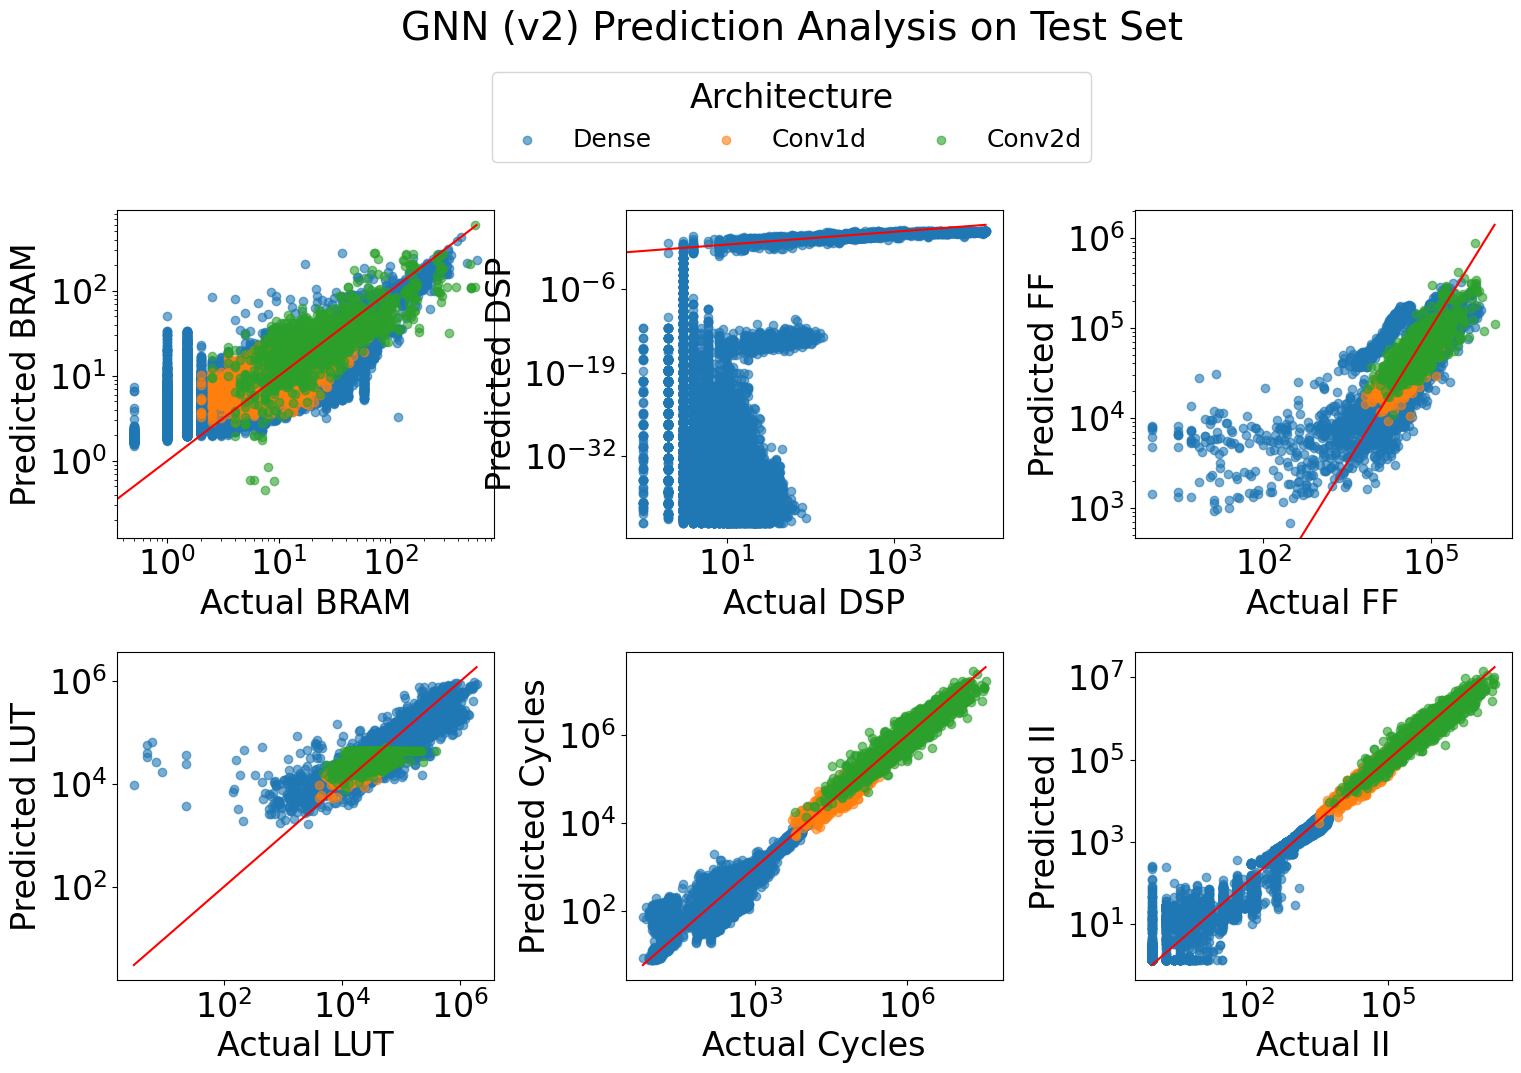

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({"font.size": 24})

unique_architectures = test_df["architecture"].unique()
if version == "v1":
    unique_architectures = ["dense"]
print(unique_architectures)
prediction_labels = [
    "bram",
    "dsp",
    "ff",
    "lut",
    "cycles",
    "interval"
]
num_plots = len(prediction_labels)
num_y = int(np.sqrt(num_plots))
num_x = int(np.ceil(np.sqrt(num_plots)))

fig, axes = plt.subplots(num_y, num_x, figsize=(6 * num_x, 10))
axes = np.reshape(axes, -1)
fig.subplots_adjust(hspace=0.35, wspace=0.35)

for i, label in enumerate(prediction_labels):
    ax_pred = axes[i]

    actual = []
    predicted = []
    scatters = []
    for architecture in unique_architectures:
        actual.extend(gns[architecture][label])
        predicted.extend(preds[architecture][label])

        scatter_legend = architecture[0].upper() + architecture[1:-1]
        if architecture.endswith("1d") or architecture.endswith("2d"):
            scatter_legend += architecture[-1].upper()
        else:
            scatter_legend += architecture[-1]

        scatters.append(
            ax_pred.scatter(
                gns[architecture][label],
                preds[architecture][label],
                alpha=0.6,
                label=architecture[0].upper() + architecture[1:]
            )
        )

    plot_label = label.upper()
    if label == "cycles":
        plot_label = "Cycles"
    elif label == "interval":
        plot_label = "II"

    # Predicted vs. Actual
    ax_pred.plot([min(actual), max(actual)], [min(actual), max(actual)], color="red")
    ax_pred.set_xlabel(f"Actual {plot_label}")
    ax_pred.set_ylabel(f"Predicted {plot_label}")
    ax_pred.set_xscale("log")
    ax_pred.set_yscale("log")

y_legend = 1.03 if test_set else 1.08
y_title = 1.08 if test_set else 1.125
legend = fig.legend(
    handles=scatters, title="Architecture", loc="upper center", bbox_to_anchor=(0.5, y_legend), fontsize=18, ncol=3
)
title = f"{estimator.upper()} ({version}) Prediction Analysis on {'Test Set' if test_set else 'Exemplar Models'}"
suptitle = fig.suptitle(title, fontsize=28, x=0.5, y=y_title)

plt.show()

In [15]:
test_label = "test_set" if test_set else "benchmark"
filename = f"{estimator.upper()}_{version}_{test_label}_scatter.png"
fig.savefig(
    filename,
    dpi=300,
    bbox_extra_artists=(suptitle, legend),
    bbox_inches="tight",
)

6


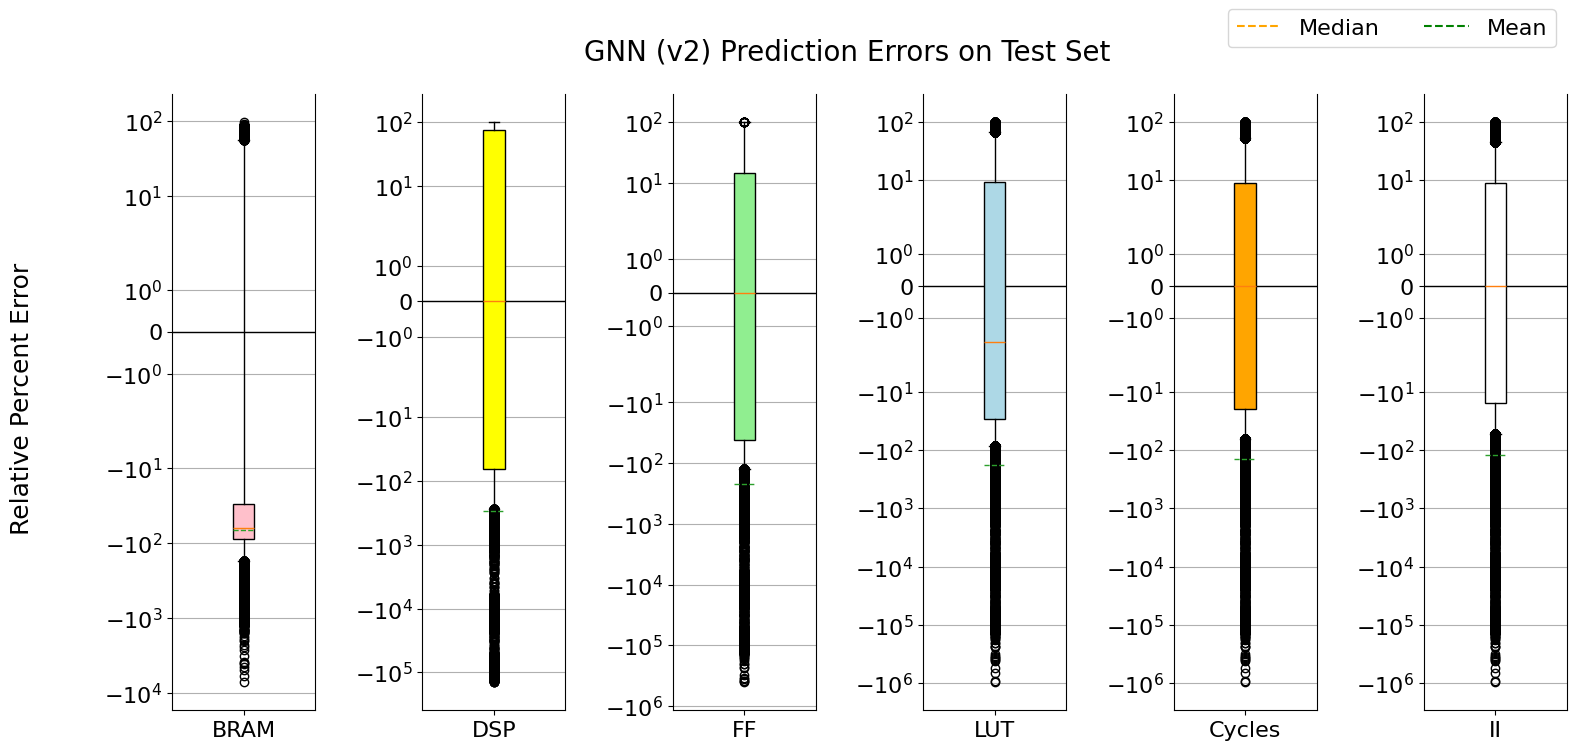

In [14]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams.update({"font.size": 16})

print(len(all_relative_percentage_errors))
fig, axis = plt.subplots(1, len(all_relative_percentage_errors), figsize=(18, 8))
axis = np.reshape(axis, -1)
fig.subplots_adjust(hspace=0.1, wspace=0.75)

iqr_weight = 1.5
colors = ["pink", "yellow", "lightgreen", "lightblue", "#FFA500", "white"]

max_abs = np.nanmax(
    [np.nanmax(np.abs(errors)) for errors in all_relative_percentage_errors.values()]
) * 1.5

for i, label in enumerate(all_relative_percentage_errors.keys()):
    errors = all_relative_percentage_errors[label]
    ax = axis[i]

    ax.axhline(0, color='black', linestyle='-', linewidth=1)

    bplot_label = label.upper()
    if label == "cycles":
        bplot_label = "Cycles"
    elif label == "interval":
        bplot_label = "II"

    bplot = ax.boxplot(
        errors,
        whis=iqr_weight,
        tick_labels=[bplot_label],
        showfliers=True,
        showmeans=True,
        meanline=True,
        vert=True,
        patch_artist=True,
    )

    for j, patch in enumerate(bplot["boxes"]):
        patch.set_facecolor(colors[(i + j) % len(colors)])

    ax.yaxis.grid(True)
    ax.spines.top.set_visible(False)
    ax.xaxis.tick_bottom()
    ax.set_yscale("symlog")

    # ax.set_ylim(-max_abs, max_abs)

median_line = Line2D([0], [0], color="orange", linestyle="--", linewidth=1.5, label="Median")
mean_line = Line2D([0], [0], color="green", linestyle="--", linewidth=1.5, label="Mean")

handles = [median_line, mean_line]
labels = ["Median", "Mean"]

legends = fig.legend(
    handles,
    labels,
    bbox_to_anchor=[0.9, 1],
    loc="upper right",
    ncol=len(labels),
)

ytext = fig.text(0.035, 0.5, "Relative Percent Error", va="center", rotation="vertical", size=18)
title = f"{estimator.upper()} ({version}) Prediction Errors on {'Test Set' if test_set else 'Exemplar Models'}"
suptitle = fig.suptitle(title, fontsize=20, y=0.95)

plt.show()

In [ ]:
filename = "MLP_benchmark_boxplot.png" if not test_set else "MLP_test_set_boxplot.png"
fig.savefig(
    filename,
    dpi=300,
    bbox_extra_artists=(legends, ytext, suptitle),
    bbox_inches="tight",
)